# Modeling HLN dataset using Neural Network 

这个教程将详细展示如何使用神经网络模型对人类淋巴结数据集(human_lymph_node)建模，包含具体的调参过程。

## 目录
* [数据预处理](#数据预处理)
  1. [读取数据](#读取数据)
* [制作数据集](#制作数据集)
  1. [标签与特征](#标签与特征)
  2. [划分数据集](#划分数据集)
* [神经网络模型](#神经网络模型)
  1. [调参](#调参)
  2. [构建模型](#构建模型)

## 数据预处理 <a class="anchor" id="数据预处理"></a>

首先，导入相关的库

In [1]:
import os
os.chdir("..")
import scanpy as sc
import numpy as np
import itertools

# 导入自己编写的库
from datapre import DataProcess as DP
from datapre import Sample as SP
from model import nn_model
from model import hyper_opt as hop
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 3
dirname = "human_lymph_node"

d:\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


设置默认的距离阈值为1.0

In [2]:
NEIGHBOR_DIS = 1.0

### 读取数据

标记线粒体基因，使用FeaturePlot函数可视化。

reading D:\work\data\V1_Human_Lymph_Node\filtered_feature_bc_matrix.h5
 (0:00:03)


d:\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


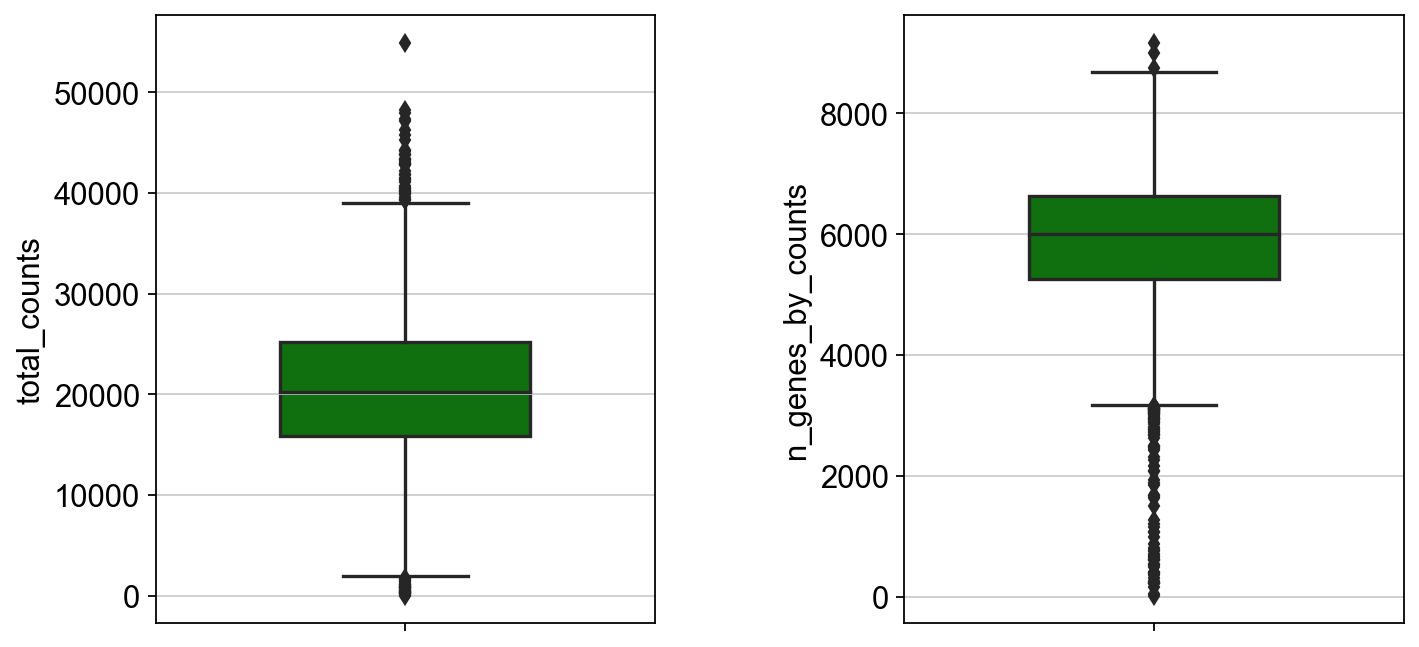

In [3]:
adata = sc.datasets.visium_sge(sample_id = "V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
DP.FeaturePlot(adata)

### 质量控制

过滤总表达量小于10的基因

In [6]:
adata

AnnData object with n_obs × n_vars = 4035 × 19834
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
sc.pp.filter_genes(adata, min_counts = 10)

filtered out 16767 genes that are detected in less than 10 counts


## 制作数据集

全局设置随机数种子

In [7]:
DP.setup_seed(38)

### 标签与特征

生成数据集标签

In [8]:
label_total, distance  = DP.CreateLabel(adata, neighbor_dis = NEIGHBOR_DIS)

运行SpaGene，识别空间可变基因

In [9]:
DP.adata2seurat(adata, "V1_Human_Lymph_Node")
! Rscript spagene.R V1_Human_Lymph_Node 1000
spagene = DP.find_Spa("data/V1_Human_Lymph_Node/spagene.txt")

Loading required package: ggplot2
Loading required package: patchwork


进行归一化、对数化、标准化

In [10]:
adata = DP.data_final(adata, spagene = spagene)
count = adata.to_df().values

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### 划分数据集

选择所有正样本，并按照1:2的比例抽取负样本

In [11]:
sample_index = SP.sample_data_index(label_total, neg_size = 2)
label, feature = SP.index2data(label_total, sample_index, count)

划分训练集和测试集

In [12]:
train_feature, train_label, test_feature, test_label = SP.split_dataset(label, feature)

train_feature = train_feature[:, 2:]
test_index = test_feature[:, [0,1]].astype("int32")
test_feature = test_feature[:, 2:]

## 神经网络模型

### 调参

这里需要优化的超参数有：
- 特征数 num_features
- 隐藏层结构 hidden_layer_sizes
- 丢弃率 dropout_rate
- 批量大小 batch_size

首先，我们进行随机搜索得到一组表现较好的超参数

In [11]:
params_1 = {
    "num_features": range(100, 800, 100),
    "hidden_layer_sizes": list(itertools.product(range(200, 600, 100), (50, 100))),
    "dropout_rate": [0.0, 0.2, 0.5],
    "batch_size": [8, 16, 32, 64]
}
nnmodel_1 = nn_model.NeuralNetworkClassifier(verbose = False)
cv1 = hop.random_search(nnmodel_1, params_1, train_feature, train_label)

d:\anaconda3\envs\scanpy\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.33718712 -0.33981861 -0.32320144 -0.3505089  -0.34462483 -0.33702892
 -0.35286486 -0.35466568 -0.34571838 -0.34735964 -0.34059112 -0.34964325
 -0.34081397 -0.33809925 -0.31169729 -0.32256152 -0.31596505 -0.34374527
 -0.33954882 -0.33582555 -0.34521647 -0.35758615 -0.33987132 -0.34526449
 -0.35593471 -0.32623248         nan -0.33982418 -0.34283233 -0.33896629]
  warnings.warn(


mean_score_time                                             0.170839
mean_test_loss                                             -0.311697
std_test_loss                                               0.004404
mean_test_auc                                               0.931794
std_test_auc                                                0.001968
rank_test_loss                                                     1
rank_test_auc                                                      1
params             {'num_features': 200, 'hidden_layer_sizes': (3...
Name: 14, dtype: object


In [12]:
cv1.best_params_

{'num_features': 200,
 'hidden_layer_sizes': (300, 100),
 'dropout_rate': 0.5,
 'batch_size': 64}

其次，在这组超参数的基础上逐个优化超参数

优化 num_features：网格搜索

mean_score_time                 0.078019
mean_test_loss                  -0.30522
std_test_loss                   0.019487
mean_test_auc                   0.935241
std_test_auc                    0.008779
rank_test_loss                         1
rank_test_auc                          1
params             {'num_features': 200}
Name: 1, dtype: object


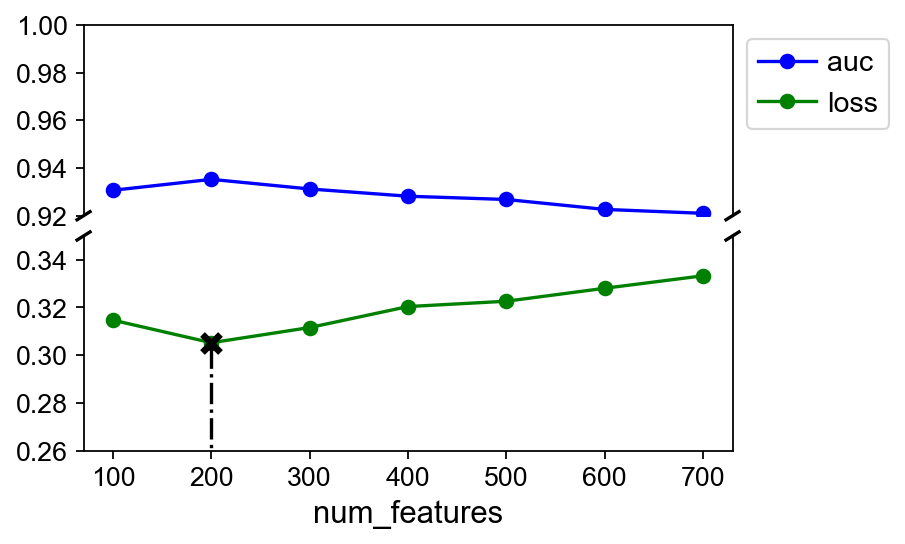

In [13]:
params_2 = {
    "num_features": range(100, 800, 100)
}
nnmodel_2 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"],
    batch_size = cv1.best_params_["batch_size"]
)
cv2 = hop.grid_search(nnmodel_2, params_2, train_feature, train_label, figname = dirname + "/NN_num_features")

In [14]:
cv2.best_params_

{'num_features': 200}

优化 batch_size：网格搜索

mean_score_time              0.083019
mean_test_loss              -0.306999
std_test_loss                0.010637
mean_test_auc                0.934521
std_test_auc                 0.004574
rank_test_loss                      1
rank_test_auc                       1
params             {'batch_size': 64}
Name: 3, dtype: object


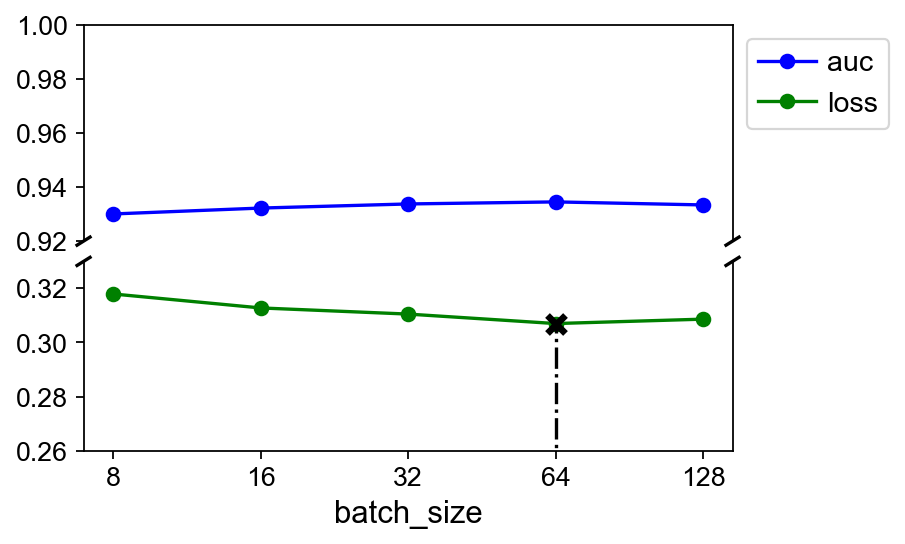

In [15]:
params_3 = {
    "batch_size": [8, 16, 32, 64, 128]
}
nnmodel_3 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv2.best_params_["num_features"], 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"]
)
cv3 = hop.grid_search(nnmodel_3, params_3, train_feature, train_label, figname = dirname + "/NN_batch_size")

In [16]:
cv3.best_params_

{'batch_size': 64}

优化 dropout_rate：网格搜索

mean_score_time                 0.069718
mean_test_loss                 -0.306007
std_test_loss                   0.009738
mean_test_auc                   0.935005
std_test_auc                    0.003952
rank_test_loss                         1
rank_test_auc                          2
params             {'dropout_rate': 0.5}
Name: 5, dtype: object


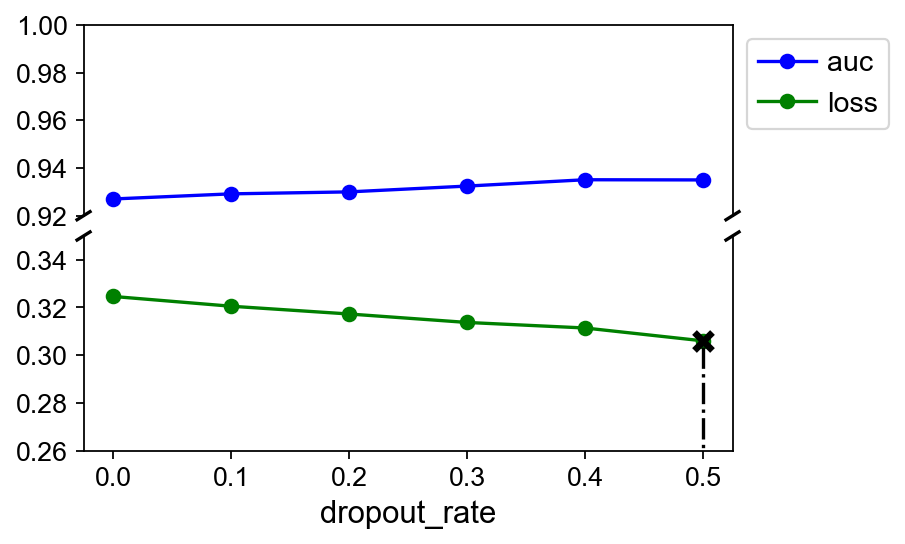

In [17]:
params_4 = {
    "dropout_rate": np.arange(0.0, 0.6, 0.1).round(1)
}
nnmodel_4 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv2.best_params_["num_features"], 
    batch_size = cv3.best_params_["batch_size"],
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"]
)
cv4 = hop.grid_search(nnmodel_4, params_4, train_feature, train_label, figname = dirname + "/NN_dropout_rate")

In [18]:
cv4.best_params_

{'dropout_rate': 0.5}

### 构建模型

第0轮，训练损失：0.4684
第0轮，验证损失：0.3919
Validation loss decreased (inf --> 0.391930).  Saving model ...
第1轮，训练损失：0.3882
第1轮，验证损失：0.3647
Validation loss decreased (0.391930 --> 0.364654).  Saving model ...
第2轮，训练损失：0.3603
第2轮，验证损失：0.3466
Validation loss decreased (0.364654 --> 0.346630).  Saving model ...
第3轮，训练损失：0.3365
第3轮，验证损失：0.3328
Validation loss decreased (0.346630 --> 0.332780).  Saving model ...
第4轮，训练损失：0.3170
第4轮，验证损失：0.3264
Validation loss decreased (0.332780 --> 0.326408).  Saving model ...
第5轮，训练损失：0.3057
第5轮，验证损失：0.3261
Validation loss decreased (0.326408 --> 0.326125).  Saving model ...
第6轮，训练损失：0.2930
第6轮，验证损失：0.3156
Validation loss decreased (0.326125 --> 0.315599).  Saving model ...
第7轮，训练损失：0.2827
第7轮，验证损失：0.3136
Validation loss decreased (0.315599 --> 0.313588).  Saving model ...
第8轮，训练损失：0.2743
第8轮，验证损失：0.3175
EarlyStopping counter: 1 out of 7
第9轮，训练损失：0.2661
第9轮，验证损失：0.3209
EarlyStopping counter: 2 out of 7
第10轮，训练损失：0.2580
第10轮，验证损失：0.3112
Validation loss decreased (0.31

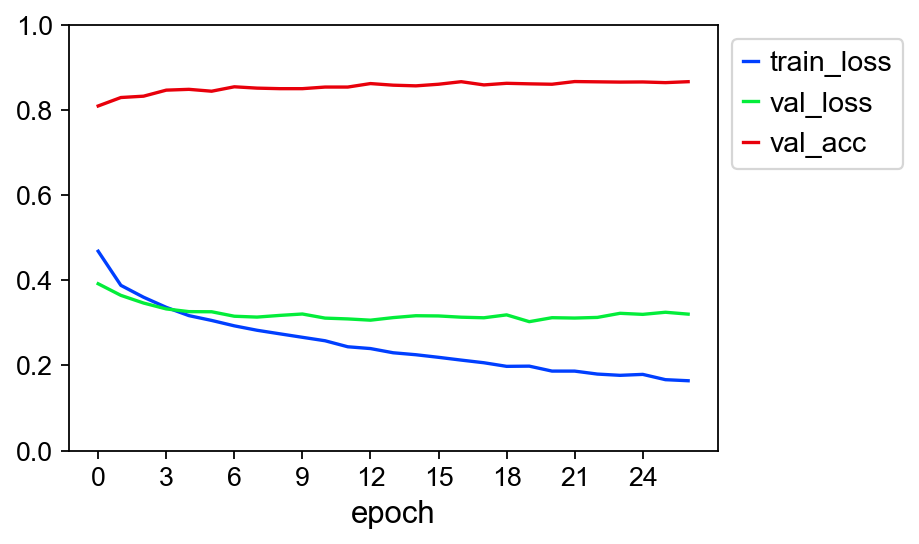

{'Accuracy': 0.8760283687943262,
 'Precision': 0.7842835130970724,
 'Recall': 0.8663829787234043,
 'MCC': 0.7303180912233166,
 'F_Score': 0.8232915487262435,
 'AUC': 0.9383404255319148,
 'Average Precision': 0.8529838388177212,
 'confusion_matrix': array([[2070,  280],
        [ 157, 1018]], dtype=int64)}

In [19]:
nnmodel = nn_model.NeuralNetworkClassifier(
    num_features = 200, 
    batch_size = 64,
    hidden_layer_sizes = [300, 100],
    dropout_rate = 0.5,
    figname = dirname + "/NN_epoch"
)
nnmodel.fit(train_feature, train_label)
pred = nnmodel.predict(test_feature)
predprob = nnmodel.predict_proba(test_feature)
eval.evaluate(test_label, pred, predprob, verbose = False)